In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Load the CSV file
df = pd.read_csv("Marital-satisfaction_Data.csv")

In [23]:
# Quick inspection
df.columns
df.head()

,Country,Gender,Age,Marriage_years,children,brought_up_children,Education,Material_status,Religion,Religiosity,...,KMSS2,KMSS3,Scale1,Scale2,Scale3,Scale4,Scale5,Scale6,Scale7,Scale8
0,Brazil,1,21.0,2.0,0,0,5,0,1.0,4,...,7,7,1,1,1,1,1,1,1,1
1,Brazil,1,29.0,3.0,1,0,5,3,1.0,6,...,6,6,2,1,1,1,1,1,1,1
2,Brazil,1,30.0,7.0,0,0,5,3,1.0,4,...,7,7,2,1,2,1,1,1,1,1
3,Brazil,1,30.0,7.0,1,1,5,3,1.0,6,...,6,6,3,1,1,2,1,1,1,1
4,Brazil,1,28.0,9.0,0,0,4,2,1.0,5,...,6,7,3,2,3,2,1,1,1,1


Data Preprocessing

In [25]:
df["Pension"] = df["Pension"].fillna(0)
df["Communication_Score"] = df[["Love1", "Love2", "Love3", "Love4", "Love5"]].mean(axis=1)
df["High_Satisfaction"] = df["Material_status"] >= 4
df["Low_Satisfaction"] = df["Material_status"] <= 2
df["Low_Education"] = df["Education"] <= 2
df["Low_Econ"] = df["Pension"] == 0
df["Childless"] = df["children"] == 0
df["Short_Marriage"] = df["Marriage_years"] < 5
df["Shared_Religion"] = df["Religiosity"] >= 6
df["Comm_High"] = df["Communication_Score"] >= 6
df["Comm_Low"] = df["Communication_Score"] < 4

Q1: Do individuals with high marital satisfaction tend to report both frequent communication and mutual decision-making?
We’ll assume:

Love1, Love2, Love3, Love4, Love5 represent relationship quality, including communication and shared decision-making

Material_status is Marital Satisfaction (rename for clarity)

1. Data Exploration 

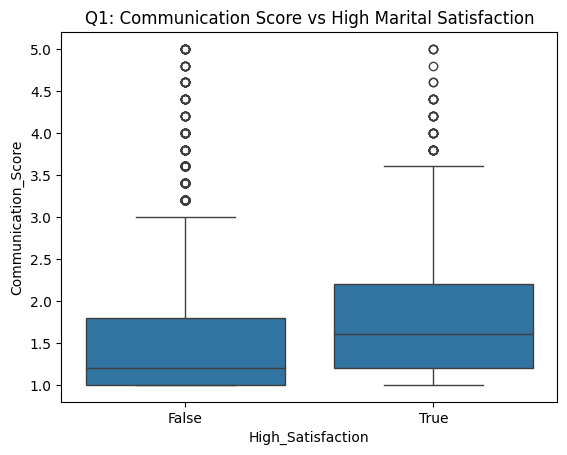

In [26]:
df["Communication_Score"] = df[["Love1", "Love2", "Love3", "Love4", "Love5"]].mean(axis=1)
df["High_Satisfaction"] = df["Material_status"] >= 4

sns.boxplot(x="High_Satisfaction", y="Communication_Score", data=df)
plt.title("Q1: Communication Score vs High Marital Satisfaction")
plt.show()

2. Association Rule Mining

In [28]:
from itertools import combinations
from collections import defaultdict

t_q1 = df.apply(lambda row: [x for x in ["High_Satisfaction", "Comm_High"] if row[x]], axis=1)

def mine_rules(transactions, min_support=0.03):
    pair_counts, item_counts = defaultdict(int), defaultdict(int)
    total = len(transactions)

    for items in transactions:
        for item in items: item_counts[item] += 1
        for pair in combinations(sorted(items), 2): pair_counts[pair] += 1

    rules = []
    for (A, B), count in pair_counts.items():
        s_ab, s_a, s_b = count/total, item_counts[A]/total, item_counts[B]/total
        conf, lift = s_ab / s_a if s_a else 0, (s_ab / s_a) / s_b if s_b else 0
        if s_ab >= min_support:
            rules.append({"Rule": f"{A} => {B}", "Support": round(s_ab, 3), "Confidence": round(conf, 3), "Lift": round(lift, 3)})

    return pd.DataFrame(rules)

rules_q1 = mine_rules(t_q1)

3. Knowledge Evaluation

In [41]:
print("Q1 Rules:")
if not rules_q1.empty:
    print(rules_q1.sort_values(by="Lift", ascending=False).head())
else:
    print("No rules generated for Q1.")

Q1 Rules:
No rules generated for Q1.


Q2: Is low marital satisfaction more prevalent among individuals with both low economic status and low education?

1. Data Exploration

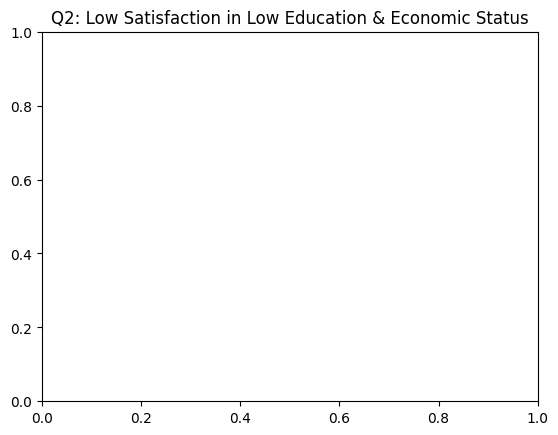

In [32]:
df["Low_Satisfaction"] = df["Material_status"] <= 2
df["Low_Education"] = df["Education"] <= 2
df["Low_Econ"] = df["Pension"].fillna(0) == 0

sns.countplot(x="Low_Satisfaction", data=df[df["Low_Education"] & df["Low_Econ"]])
plt.title("Q2: Low Satisfaction in Low Education & Economic Status")
plt.show()

2. Association Rule Mining

In [33]:
t_q2 = df.apply(lambda row: [x for x in ["Low_Satisfaction", "Low_Education", "Low_Econ"] if row[x]], axis=1)
rules_q2 = mine_rules(t_q2)

3. Knowledge Evaluation

In [42]:
print("Q2 Rules:")
if not rules_q2.empty:
    print(rules_q2.sort_values(by="Lift", ascending=False).head())
else:
    print("No rules generated for Q2.")

Q2 Rules:
No rules generated for Q2.


Q3: Are childless couples with short marriage durations more likely to report dissatisfaction?
Assume:

No children: children == 0

Short marriage: Marriage_years < 5

Low satisfaction: ≤ 2

1. Data Exploration

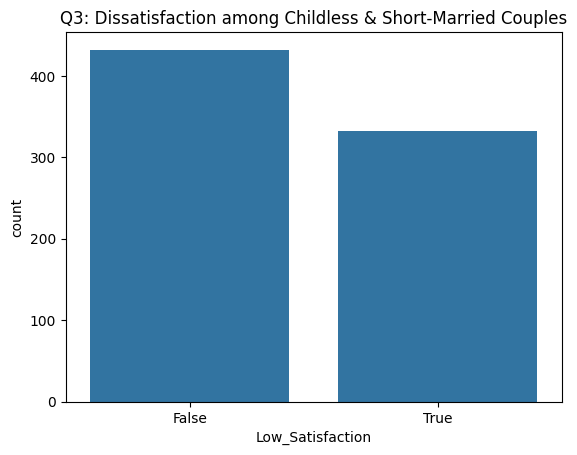

In [35]:
df["Childless"] = df["children"] == 0
df["Short_Marriage"] = df["Marriage_years"] < 5

sns.countplot(x="Low_Satisfaction", data=df[df["Childless"] & df["Short_Marriage"]])
plt.title("Q3: Dissatisfaction among Childless & Short-Married Couples")
plt.show()

2. Association Rule Mining

In [36]:
t_q3 = df.apply(lambda row: [x for x in ["Low_Satisfaction", "Childless", "Short_Marriage"] if row[x]], axis=1)
rules_q3 = mine_rules(t_q3)

3. Knowledge Evaluation

In [43]:
print("Q3 Rules:")
if not rules_q3.empty:
    print(rules_q3.sort_values(by="Lift", ascending=False).head())
else:
    print("No rules generated for Q3.")

Q3 Rules:
                                 Rule  Support  Confidence   Lift
1         Childless => Short_Marriage    0.106       0.721  3.076
0       Childless => Low_Satisfaction    0.065       0.442  1.133
2  Low_Satisfaction => Short_Marriage    0.103       0.264  1.127


Q4: Does higher satisfaction associate with shared religious beliefs, regardless of income or education?
Assume:

Shared beliefs = high Religiosity (≥ 6)

High satisfaction = Marital_satisfaction ≥ 4

1. Data Exploration

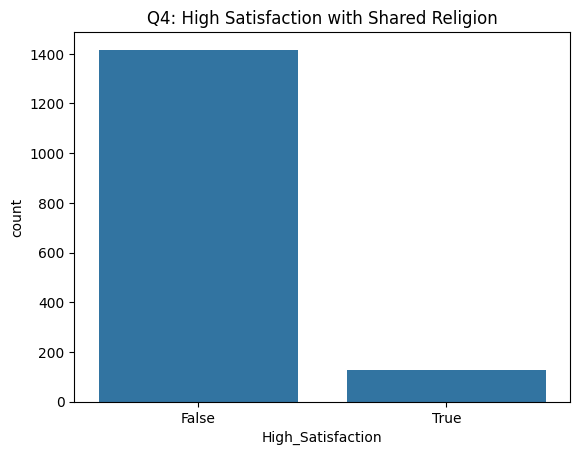

In [38]:
df["Shared_Religion"] = df["Religiosity"] >= 6

sns.countplot(x="High_Satisfaction", data=df[df["Shared_Religion"]])
plt.title("Q4: High Satisfaction with Shared Religion")
plt.show()

2. Association Rule Mining

In [39]:
t_q4 = df.apply(lambda row: [x for x in ["High_Satisfaction", "Shared_Religion"] if row[x]], axis=1)
rules_q4 = mine_rules(t_q4)

3. Knowledge Evaluation

In [44]:
print("Q4 Rules:")
if not rules_q4.empty:
    print(rules_q4.sort_values(by="Lift", ascending=False).head())
else:
    print("No rules generated for Q4.")

Q4 Rules:
No rules generated for Q4.
